In [2]:
# setup in requirements
#!pip install pandas numpy spacy nltk scikit-learn gensim matplotlib seaborn pyLDAvis
#!python -m spacy download en_core_web_sm
import pandas as pd
import re
import spacy
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from gensim import corpora, models
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [3]:
#datei muss zuvor herunter geladen worden sein
df = pd.read_csv("311_Service_Requests_from_2010_to_Present.csv.csv")
# in Tabelle öffnen, um ggf. richtige Spalte auszuwählen
# df.head()

C:\Users\Asus\AppData\Local\Temp\ipykernel_12212\3946642945.py:2: DtypeWarning: Columns (48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("311_Service_Requests_from_2010_to_Present.csv.csv")


In [4]:
# richtige spalte zum bearbeiten auswählen
# Aus Datensatz wird 'Descriptor' 
text_col = "Descriptor" 
df = df[[text_col]].dropna()

# Begrenzung aus Performancegründen für Testzwecke
df = df.sample(n=1000, random_state=42)


# Leere Felder werden gelöscht
df = df[df[text_col].str.strip() != '']

In [5]:
#Textverarbeitung
# Stopword werden in Englisch herunterladen
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# spaCy Modell laden
nlp = spacy.load("en_core_web_sm")

# Bereinigungsfunktion
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Sonderzeichen entfernen
    doc = nlp(text)
    lemmatized = [token.lemma_ for token in doc if token.text not in stop_words and not token.is_stop]
    return " ".join(lemmatized)

# Anwenden
df["clean_text"] = df[text_col].apply(clean_text)
# saubere Texte nun vorhanden

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Vektorisierungsverfahren 1
# Termfrequency - Inverse document frequency
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=1, max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df["clean_text"])

In [7]:
# Vektorisierungsverfahren 2
doc = nlp(df["clean_text"].iloc[0])
doc.vector

array([-0.03104296, -0.65909135, -0.03626274, -0.09698124, -0.33765924,
       -0.14419317,  0.68829226,  0.77022696, -0.06356911, -0.6710899 ,
        0.8672027 , -0.3301526 , -0.43614998, -0.40765655, -0.53085554,
       -0.34728986,  0.13295552, -0.17185307,  0.35447323, -0.7590897 ,
       -1.1257399 ,  0.9936148 , -0.23682217,  0.2513254 , -0.00334284,
        0.43724042,  0.20167503, -0.30141345, -1.1068559 ,  1.006225  ,
       -0.05401848,  0.29474437, -0.07308936,  1.0825241 , -0.05140445,
       -0.14212027, -0.06115642,  0.49774176, -0.31779397, -0.450235  ,
       -0.59166974, -0.2989464 , -0.64879715,  1.0858569 , -0.21541816,
        1.5218732 , -0.41960785,  0.12405089, -0.12250645, -0.08960216,
       -0.1489324 ,  0.23958345, -0.7311493 , -0.51363444, -0.34918776,
        0.01820713,  0.9909389 ,  0.24122968, -0.1894242 ,  0.8074157 ,
       -0.27942938,  0.12449465,  0.03519711, -0.5126204 , -0.3409868 ,
        0.1752504 ,  0.84358656,  0.32230377, -0.5643357 , -0.56

In [8]:
#Vergleich der Vektorisierungsverfahren
print("TF-IDF Shape:", tfidf_matrix.shape)
print("Word Embedding Shape (spaCy):", nlp(df["clean_text"].iloc[0]).vector.shape)

TF-IDF Shape: (1000, 48)
Word Embedding Shape (spaCy): (96,)


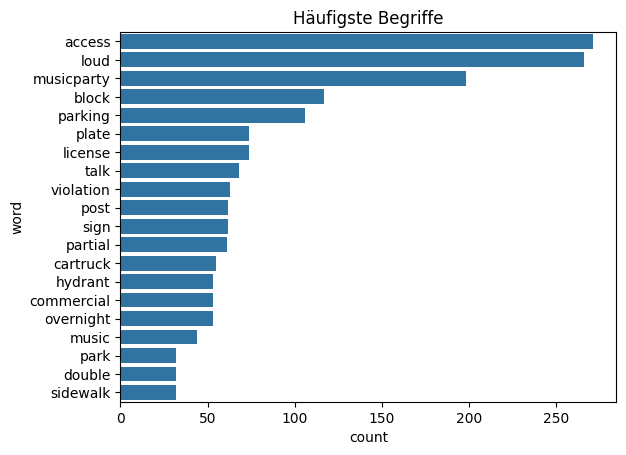

In [9]:
# semantische Analysetechnik 1
# Unigramme erstellen
vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(df["clean_text"])
words = vectorizer.get_feature_names_out()
sums = X.sum(axis=0).A1

freq_df = pd.DataFrame({"word": words, "count": sums})
sns.barplot(data=freq_df.sort_values("count", ascending=False), x="count", y="word")
plt.title("Häufigste Begriffe")
plt.show()

In [10]:
# semantische Analysetechnik 2
# Topic Modeling mit Latent Dirichlet Allocation
# Tokenisierung
texts = [text.split() for text in df["clean_text"]]

# Dictionary und Korpus auswählen
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]



In [11]:
# LDA-Modell Rahmenbedingungen werden dynamisch gesetzt, Rechenintensiv
# Alternative harte eingabe der Themenmenge
# lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=10, random_state=42)
processed_texts = [text.split() for text in df["clean_text"]]


# Bereich der zu testenden Topic-Zahlen
min_topics = 2
max_topics = 20
coherence_scores = []
models_list = []

for n in range(min_topics, max_topics + 1):
    lda_model = models.LdaModel(corpus=corpus,
                                id2word=dictionary,
                                num_topics=n,
                                passes=10,
                                random_state=42)

    coherence_model = CoherenceModel(model=lda_model,
                                     texts=processed_texts,
                                     dictionary=dictionary,
                                     coherence='c_v')
    coherence = coherence_model.get_coherence()

    coherence_scores.append(coherence)
    models_list.append(lda_model)

    print(f"Anzahl Topics = {n}, Coherence Score = {coherence:.4f}")

# Beste Anzahl an Topics finden
best_index = coherence_scores.index(max(coherence_scores))
best_n = best_index + min_topics
best_model = models_list[best_index]
best_score = coherence_scores[best_index]

print(f"\n✅ Bestes Modell hat {best_n} Topics mit einem Coherence Score von {best_score:.4f}")


lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=best_n, passes=10, random_state=42)

# Themen anzeigen zur Kontrolle
# for idx, topic in lda_model.print_topics(-1):
#    print(f"🔹 Thema {idx}: {topic}")

Anzahl Topics = 2, Coherence Score = 0.7010
Anzahl Topics = 3, Coherence Score = 0.7049
Anzahl Topics = 4, Coherence Score = 0.7071
Anzahl Topics = 5, Coherence Score = 0.7134
Anzahl Topics = 6, Coherence Score = 0.6957
Anzahl Topics = 7, Coherence Score = 0.7031
Anzahl Topics = 8, Coherence Score = 0.7075
Anzahl Topics = 9, Coherence Score = 0.7135
Anzahl Topics = 10, Coherence Score = 0.7118
Anzahl Topics = 11, Coherence Score = 0.7098
Anzahl Topics = 12, Coherence Score = 0.7071
Anzahl Topics = 13, Coherence Score = 0.7159
Anzahl Topics = 14, Coherence Score = 0.7208
Anzahl Topics = 15, Coherence Score = 0.7196
Anzahl Topics = 16, Coherence Score = 0.7133
Anzahl Topics = 17, Coherence Score = 0.7240
Anzahl Topics = 18, Coherence Score = 0.7176
Anzahl Topics = 19, Coherence Score = 0.7146
Anzahl Topics = 20, Coherence Score = 0.7138

✅ Bestes Modell hat 17 Topics mit einem Coherence Score von 0.7240


In [12]:
# Visualisierung der Ergebnisse
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

In [13]:
# die dynamische Analyse des Coherence Score empfiehlt eine Anzahl an Themen und nutzt diese automatisch
# Die Graphische Aufbereitung lässt auf den ersten Blick Schwerpunkte der Themenfelder erkennen.
# Dadurch ist nicht nur ersichtlich, in welche Themengebiete sich die Beschwerden aufteilen, sondern auch, bei welchen Themen es Überschneidungen gibt.
# Diese ist nicht für jeden intuitiv interpretierbar, weshalb eine zweite Darstellung mit den Unigrammen sinnvoll erscheint.